# 3. Regression
In this notebook we will finally run our regression models. For that purpose, we are importing the necessary libraries and functions from our ```modules``` folder. We are also importing our extracted dataframe

In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats
from functools import reduce

# Statsmodels
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning models
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    precision_score

)

from xgboost import XGBRegressor



In [2]:
# We import our own functions
import sys
sys.path.append('../../..')  # Move two levels up to the project root
from modules.functions import *

In [3]:
df = pd.read_csv('../../../input/df_raw_h23.csv', parse_dates=['Fecha'], index_col='Fecha')
df.tail()

,CPI,CPI Tradable,CPI Non-Tradable,CPI Core,CPI Non-Core,CPI Food and Energy,CPI Excluding Food and Energy,CPI Food and Beverages,CPI Excluding Food and Beverages,CPI Core Excluding Food and Beverages,CPI Imported,Wholesale Price Index,Reserve Requirement Rate,Monetary Policy Rate,Circulating Currency Seasonally Adjusted (mill S/),Net International Reserves (mill $),Real Minimum Wage (Index)
Fecha,,,,,,,,,,,,,,,,,
2023-08-01,0.182324,0.263821,0.147377,0.308731,-0.071459,0.175741,0.189515,0.263738,0.125240,0.215058,-0.170008,-0.104763,5.137951,7.75,-0.002584,-0.019404,-0.003747
2023-09-01,0.133933,0.237390,0.089467,0.281829,-0.163217,0.099223,0.165369,0.179682,0.102272,0.195769,-0.206148,-0.125837,5.269584,7.50,0.002271,-0.008615,-0.000164
2023-10-01,0.085365,0.210974,0.031289,0.254555,-0.254697,0.022078,0.141472,0.094521,0.079821,0.176261,-0.240150,-0.144366,5.277209,7.25,0.006684,-0.001206,0.003235
2023-11-01,0.036736,0.184472,-0.026935,0.226933,-0.345597,-0.055512,0.117886,0.008508,0.057913,0.156596,-0.272242,-0.160344,5.625714,7.00,-0.002776,0.008482,0.001633
2023-12-01,-0.011845,0.157822,-0.085018,0.198984,-0.435639,-0.133358,0.094639,-0.078087,0.036539,0.136819,-0.302719,-0.173843,5.857378,6.75,-0.013468,-0.010011,-0.003992


In [4]:
df_lags = pd.read_csv('../../../input/df_lags_h23.csv', parse_dates=['Fecha'], index_col='Fecha')
df_lags.tail()

,CPI,CPI Tradable_lag_1,CPI Tradable_lag_2,CPI Non-Tradable_lag_1,CPI Non-Tradable_lag_2,CPI Core_lag_1,CPI Core_lag_2,CPI Non-Core_lag_1,CPI Non-Core_lag_2,CPI Food and Energy_lag_1,...,Reserve Requirement Rate_lag_1,Reserve Requirement Rate_lag_2,Monetary Policy Rate_lag_1,Monetary Policy Rate_lag_2,Circulating Currency Seasonally Adjusted (mill S/)_lag_1,Circulating Currency Seasonally Adjusted (mill S/)_lag_2,Net International Reserves (mill $)_lag_1,Net International Reserves (mill $)_lag_2,Real Minimum Wage (Index)_lag_1,Real Minimum Wage (Index)_lag_2
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0.182324,0.290249,0.316561,0.204813,0.261591,0.335223,0.361269,0.020204,0.111347,0.251427,...,5.617809,5.985237,7.75,7.75,-0.017678,-0.011038,0.004548,-0.043297,-0.003909,0.001566
2023-09-01,0.133933,0.263821,0.290249,0.147377,0.204813,0.308731,0.335223,-0.071459,0.020204,0.175741,...,5.137951,5.617809,7.75,7.75,-0.002584,-0.017678,-0.019404,0.004548,-0.003747,-0.003909
2023-10-01,0.085365,0.237390,0.263821,0.089467,0.147377,0.281829,0.308731,-0.163217,-0.071459,0.099223,...,5.269584,5.137951,7.50,7.75,0.002271,-0.002584,-0.008615,-0.019404,-0.000164,-0.003747
2023-11-01,0.036736,0.210974,0.237390,0.031289,0.089467,0.254555,0.281829,-0.254697,-0.163217,0.022078,...,5.277209,5.269584,7.25,7.50,0.006684,0.002271,-0.001206,-0.008615,0.003235,-0.000164
2023-12-01,-0.011845,0.184472,0.210974,-0.026935,0.031289,0.226933,0.254555,-0.345597,-0.254697,-0.055512,...,5.625714,5.277209,7.00,7.25,-0.002776,0.006684,0.008482,-0.001206,0.001633,0.003235


## 3.1 Benchmark models

In the first section, we first run our benchmark econometric models: ```Random Walk (RW)```,  ```Autoregressive Integrated Moving Average (ARIMA)``` and ```Vector Autoregression (VAR)``` processes

### 3.1.1 Random Walk (RW)

In [5]:
forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# We define our target variable
target = 'CPI'

# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2023-01-01']
test_set  = df_CPI[df_CPI.index >= '2023-01-01']

predictions = {}

for h in forecast_horizons:
    # We get the values h horizons before
    predicted_value = train_set.iloc[-1, 0] 

    # We save it for horizon h
    predictions[h] = predicted_value

predicted = pd.DataFrame([predictions]).transpose().reset_index()

predicted.columns = ['Horizon', 'Prediction']

predicted = predicted.set_index(test_set.index)

predicted

,Horizon,Prediction
Fecha,,
2023-01-01,1,0.560176
2023-02-01,2,0.560176
2023-03-01,3,0.560176
2023-04-01,4,0.560176
2023-05-01,5,0.560176
2023-06-01,6,0.560176
2023-07-01,7,0.560176
2023-08-01,8,0.560176
2023-09-01,9,0.560176


In [6]:
# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'Horizon': 'Horizon', 'Prediction': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Horizon,Predicted,Actual
Fecha,,,
2023-01-01,1,0.560176,0.514333
2023-02-01,2,0.560176,0.464964
2023-03-01,3,0.560176,0.417904
2023-04-01,4,0.560176,0.371486
2023-05-01,5,0.560176,0.324949
2023-06-01,6,0.560176,0.277964
2023-07-01,7,0.560176,0.230389
2023-08-01,8,0.560176,0.182324
2023-09-01,9,0.560176,0.133933


In [7]:
# We get our metrics using our function
RMSE_rw, MAPE_rw = get_metrics(results, 'RW')
metrics_rw = pd.concat([RMSE_rw, MAPE_rw], axis = 1)
metrics_rw

,RMSE_RW,MAPE_RW
1,0.045843,0.089131
2,0.074723,0.146953
3,0.102320,0.211449
4,0.129434,0.285570
5,0.156425,0.373234
6,0.183479,0.480242
7,0.210695,0.616127
8,0.238096,0.798162
9,0.265665,1.063088
10,0.293368,1.512994


### 3.1.2 Autoregressive Integrated Moving Average (ARIMA)

In [8]:
# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2023-01-01']
test_set  = df_CPI[df_CPI.index >= '2023-01-01']

In [9]:
# We find the best SARIMA model
autoarima = pmd.auto_arima(
        y = train_set,
        start_p=1,
        start_q=0,
        seasonal=True,
        max_p=12,
        max_d=1,
        max_q=6,
        max_P=12,
        max_D=1,
        max_Q=6,
        m=4,
        n_jobs=-1,
        suppress_warnings=True,
        )

# We indicate the seasonal order for monthly data
seasonal_order = (1, 1, 1, 12)

# We create our ARIMA model
model = SARIMAX(train_set,
                order=autoarima.order,
                seasonal_order=autoarima.seasonal_order,
                enforce_stationarity = False,
                enforce_invertibility = False)
        
# We fit the model
model_fit = model.fit()

# We forecast for the next 12 horizons
forecast_values = model_fit.get_forecast(steps=12)
predicted = pd.DataFrame(forecast_values.predicted_mean, index = test_set.index)

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'predicted_mean': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2023-01-01,0.514609,0.514333
2023-02-01,0.467577,0.464964
2023-03-01,0.420493,0.417904
2023-04-01,0.373576,0.371486
2023-05-01,0.327637,0.324949
2023-06-01,0.282950,0.277964
2023-07-01,0.240101,0.230389
2023-08-01,0.200149,0.182324
2023-09-01,0.164588,0.133933


In [10]:
# We get our metrics using our function
RMSE_arima, MAPE_arima = get_metrics(results, 'ARIMA')
metrics_arima= pd.concat([RMSE_arima, MAPE_arima], axis = 1)
metrics_arima

,RMSE_ARIMA,MAPE_ARIMA
1,0.000276,0.000537
2,0.001858,0.003079
3,0.002130,0.004118
4,0.002120,0.004495
5,0.002245,0.005251
6,0.002889,0.007366
7,0.004542,0.012335
8,0.007600,0.023014
9,0.012480,0.045888
10,0.019589,0.099108


### 3.1.3 Vector autoregression (VAR)

In [11]:
# We define our target variable, as well as our train and test set
target = 'CPI'
train_set = df[df.index < '2023-01-01']
test_set  = df[df.index >= '2023-01-01']

In [12]:
# We model our VAR including up to two lags
model_var = VAR(df)
model_fit = model_var.fit(2)

In [13]:
# We forecast for the next 12 months
preds = model_fit.forecast(df.values[-2:], 12)
preds = pd.DataFrame(preds, index = test_set[target].index)[0]

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([preds, test_set[target]],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2023-01-01,-0.055256,0.514333
2023-02-01,-0.094044,0.464964
2023-03-01,-0.129505,0.417904
2023-04-01,-0.162714,0.371486
2023-05-01,-0.194639,0.324949
2023-06-01,-0.226175,0.277964
2023-07-01,-0.258046,0.230389
2023-08-01,-0.290762,0.182324
2023-09-01,-0.324596,0.133933


In [14]:
# We get our metrics using our function
RMSE_var, MAPE_var = get_metrics(results, 'VAR')
metrics_var= pd.concat([RMSE_var, MAPE_var], axis = 1)
metrics_var

,RMSE_VAR,MAPE_VAR
1,0.569589,1.107433
2,0.564323,1.154847
3,0.558742,1.206529
4,0.552709,1.264399
5,0.546245,1.331316
6,0.539456,1.411711
7,0.532467,1.512901
8,0.525411,1.648133
9,0.518406,1.845402
10,0.511534,2.182076


<Axes: >

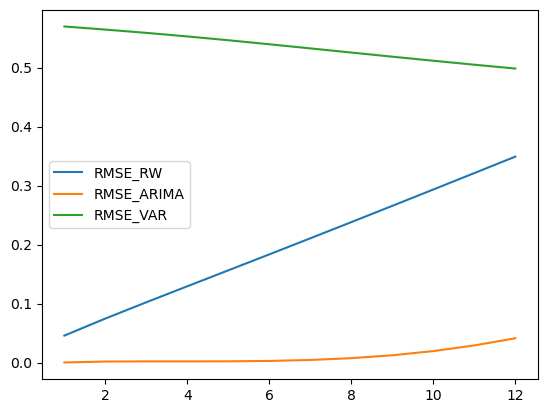

In [15]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_arima, RMSE_var], axis=1)

rmse_econometrics.plot()

## 3.2 Machine learning models

In the second section, we run our machine learning models: ```Ridge Regression (Ridge)```,  ```Least Absolute Shrinkage and Selection Operator (LASSO)``` and ```Random Forest (RF)``` models

### 3.2.1 Ridge Regression (Ridge)

In [16]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
import sklearn.linear_model as skl
ridge = skl.ElasticNet(l1_ratio=0)
model = ridge

# We define out lambdas and implement our gridparams
lambdas    = np.linspace(0.0001, 1, 1000)

grid_params = {'alpha': lambdas}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [17]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.coef_
vars_df_ridge      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
vars_df_ridge      = vars_df_ridge.reindex( vars_df_ridge[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_ridge.to_excel( f'../../../output/3_Regression/h23/h23coef_ridge.xlsx' )

In [18]:
# We use the best model to predict
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
print(y_pred)

Fecha
2023-01-01    0.516628
2023-02-01    0.467954
2023-03-01    0.421791
2023-04-01    0.375833
2023-05-01    0.330035
2023-06-01    0.284188
2023-07-01    0.237098
2023-08-01    0.189977
2023-09-01    0.141249
2023-10-01    0.092409
2023-11-01    0.043555
2023-12-01   -0.005009
dtype: float64


In [19]:
# And concatenate the results
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2023-01-01,0.516628,0.514333
2023-02-01,0.467954,0.464964
2023-03-01,0.421791,0.417904
2023-04-01,0.375833,0.371486
2023-05-01,0.330035,0.324949
2023-06-01,0.284188,0.277964
2023-07-01,0.237098,0.230389
2023-08-01,0.189977,0.182324
2023-09-01,0.141249,0.133933


In [20]:
RMSE_ridge, MAPE_ridge = get_metrics(results, 'Ridge')

<Axes: >

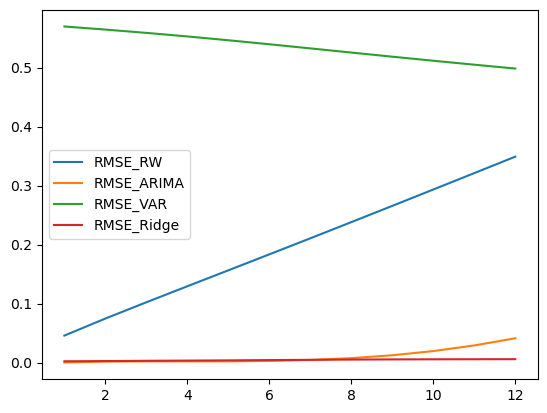

In [21]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge], axis=1).plot()

### 3.2.2 Lasso Regression (Lasso)

In [22]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
import sklearn.linear_model as skl
lasso = skl.ElasticNet( l1_ratio=1, random_state = 2024 )
model = lasso

# We define out lambdas and implement our gridparams
lambdas    = np.linspace(0.0001, 1, 1000)
grid_params = {'alpha': lambdas}

# We implement the gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [23]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.coef_
vars_df_lasso      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
vars_df_lasso      = vars_df_lasso.reindex( vars_df_lasso[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_lasso.to_excel( f'../../../output/3_Regression/h23/h23coef_lasso.xlsx' )

In [24]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [25]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2023-01-01,0.512770,0.514333
2023-02-01,0.464811,0.464964
2023-03-01,0.418600,0.417904
2023-04-01,0.373839,0.371486
2023-05-01,0.328598,0.324949
2023-06-01,0.282642,0.277964
2023-07-01,0.236498,0.230389
2023-08-01,0.189913,0.182324
2023-09-01,0.142294,0.133933


In [26]:
RMSE_lasso, MAPE_lasso = get_metrics(results, 'Lasso')

<Axes: >

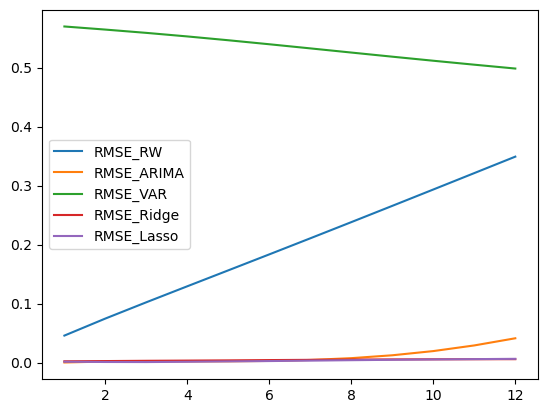

In [27]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso], axis=1).plot()

### 3.2.3 Random Forest Regression (Random Forest)

In [28]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor( random_state = 2024, n_jobs = -1 )
model = random_forest

# We define out lambdas and implement our gridparams
n_estimators = [5, 6, 10, 12, 15]

max_depth = [10, 20, 30, 50]

grid_params = {'n_estimators': n_estimators, 'max_depth': max_depth}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [29]:
pred_vars = X_train.columns.to_list()
feature_importances = best_model.feature_importances_
vars_df_rf             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
vars_df_rf             = vars_df_rf.reindex(vars_df_rf[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
vars_df_rf.to_excel( f'../../../output/3_Regression/h23/h23coef_rf.xlsx' )

In [30]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [31]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2023-01-01,0.567784,0.514333
2023-02-01,0.494393,0.464964
2023-03-01,0.437559,0.417904
2023-04-01,0.390860,0.371486
2023-05-01,0.320920,0.324949
2023-06-01,0.296008,0.277964
2023-07-01,0.239035,0.230389
2023-08-01,0.221063,0.182324
2023-09-01,0.109761,0.133933


In [32]:
RMSE_rf, MAPE_rf = get_metrics(results, 'RF')

## 3.3 Results
Here we concat all results into a single dataframe. We export the table to excel.


### 3.3.1 General results
Here we will create graphs and tables with the results of all models combined into a single datagrame.

In [33]:
RMSE_2019 = pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso, RMSE_rf], axis=1)
MAPE_2019 = pd.concat([MAPE_rw, MAPE_arima, MAPE_var, MAPE_ridge, MAPE_lasso, MAPE_rf], axis=1)

<Axes: >

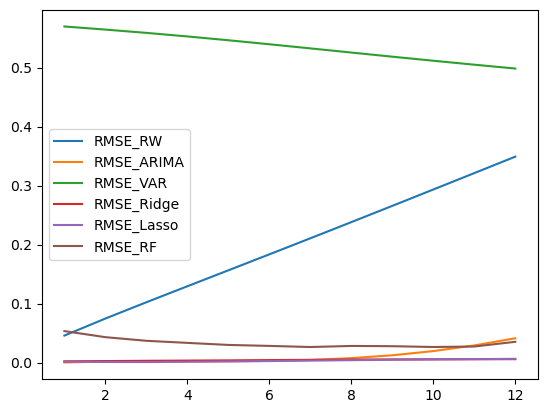

In [34]:
RMSE_2019.plot()

In [35]:
RMSE_2019_results = RMSE_2019.div(RMSE_rw['RMSE_RW'], axis=0)
RMSE_2019_results = RMSE_2019_results.drop(columns=['RMSE_RW'])
RMSE_2019_results_highlight = RMSE_2019_results.style.apply(highlight_min, axis=1)
RMSE_2019_results_highlight

,RMSE_ARIMA,RMSE_VAR,RMSE_Ridge,RMSE_Lasso,RMSE_RF
1,0.006023,12.424751,0.050069,0.034100,1.165960
2,0.024870,7.552228,0.035671,0.014864,0.577410
3,0.020817,5.460724,0.030553,0.009694,0.361717
4,0.016380,4.270212,0.026825,0.011256,0.258698
5,0.014354,3.492057,0.024609,0.013351,0.191807
6,0.015745,2.940146,0.023636,0.014707,0.154582
7,0.021556,2.527190,0.022538,0.016145,0.125590
8,0.031921,2.206718,0.021844,0.017481,0.118813
9,0.046978,1.951352,0.020614,0.018116,0.104875
10,0.066771,1.743661,0.019269,0.018438,0.090331


In [36]:
MAPE_2019_results = MAPE_2019.div(MAPE_rw['MAPE_RW'], axis=0)
MAPE_2019_results = MAPE_2019_results.drop(columns=['MAPE_RW'])
MAPE_2019_results_highlight = MAPE_2019_results.style.apply(highlight_min, axis=1)
MAPE_2019_results_highlight

,MAPE_ARIMA,MAPE_VAR,MAPE_Ridge,MAPE_Lasso,MAPE_RF
1,0.006023,12.424751,0.050069,0.034100,1.165960
2,0.020952,7.858644,0.037065,0.011461,0.568947
3,0.019474,5.706011,0.031836,0.007935,0.337748
4,0.015741,4.427633,0.027925,0.009953,0.233219
5,0.014068,3.566974,0.025481,0.012110,0.149397
6,0.015337,2.939579,0.024274,0.013684,0.119286
7,0.020020,2.455504,0.022969,0.015289,0.088397
8,0.028834,2.064909,0.022087,0.016845,0.092982
9,0.043165,1.735888,0.020450,0.017766,0.080917
10,0.065505,1.442224,0.018386,0.018336,0.055831


In [37]:
tableH19 = RMSE_rw.join(RMSE_2019_results)
tableH19 = tableH19.rename(columns = {'RMSE_RW': 'Benchmark', 'RMSE_ARIMA': 'ARIMA', 'RMSE_VAR': 'VAR', 'RMSE_Ridge': 'Ridge', 
                            'RMSE_Lasso': 'Lasso', 'RMSE_RF':'RF'})
tableH19.index.name = 'horizon'
tableH19.to_excel("../../../output/3_Regression/h23/h23table_rmse.xlsx")

In [38]:
tableH19 = MAPE_rw.join(MAPE_2019_results)
tableH19 = tableH19.rename(columns = {'MAPE_RW': 'Benchmark', 'MAPE_ARIMA': 'ARIMA', 'MAPE_VAR': 'VAR', 'MAPE_Ridge': 'Ridge', 
                            'MAPE_Lasso': 'Lasso', 'MAPE_RF':'RF'})
tableH19.index.name = 'horizon'
tableH19.to_excel("../../../output/3_Regression/h23/h23table_mape.xlsx")

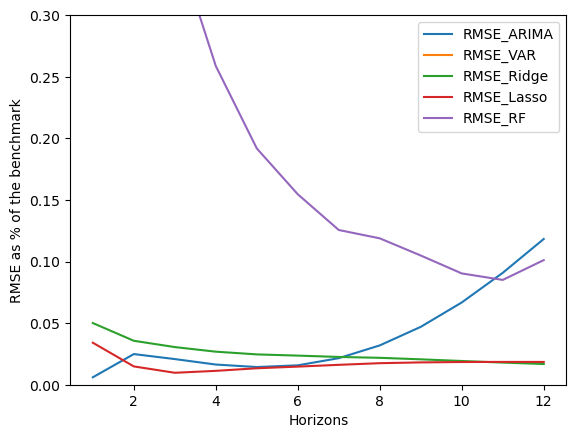

<Figure size 640x480 with 0 Axes>

In [39]:
graph_models(RMSE_2019_results, lim=0.3)

plt.savefig("../../../output/3_Regression/h23/h23_rmse.png", bbox_inches='tight', dpi=300)

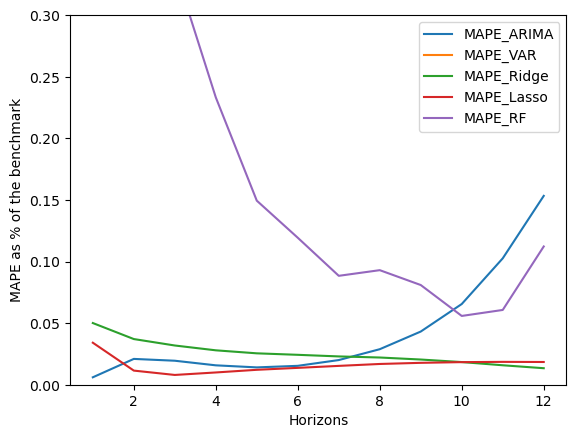

<Figure size 640x480 with 0 Axes>

In [40]:
graph_models(MAPE_2019_results, metric = "MAPE", lim=0.3)

plt.savefig("../../../output/3_Regression/h23/h23_mape.png", bbox_inches='tight', dpi=300)

### 3.3.2 Coefficients by model

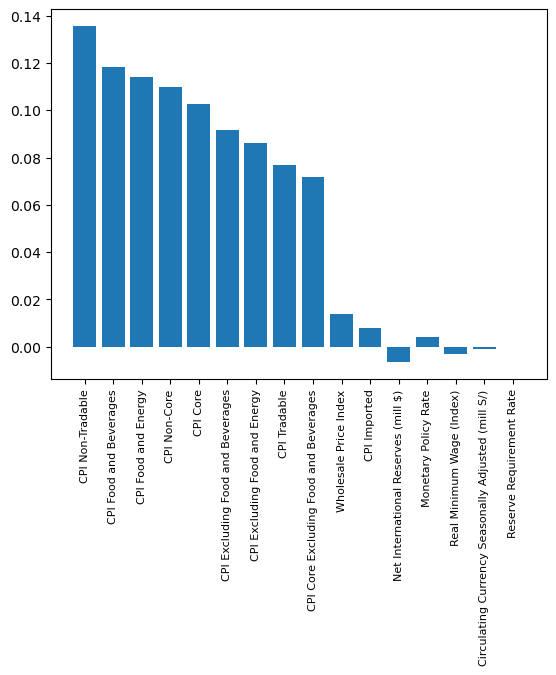

<Figure size 640x480 with 0 Axes>

In [41]:
graph_coefficients(vars_df_ridge, value = "Coefficient")

plt.savefig("../../../output/3_Regression/h23/h23_coef_ridge.png", bbox_inches='tight', dpi=300)

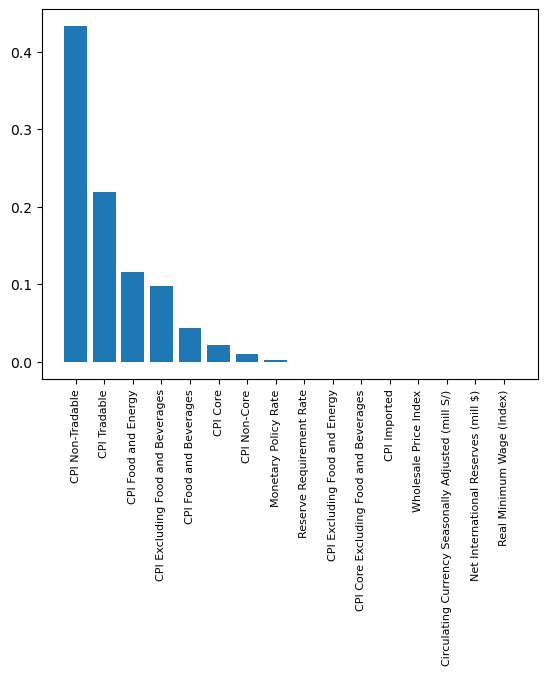

<Figure size 640x480 with 0 Axes>

In [42]:
graph_coefficients(vars_df_lasso, value = "Coefficient")

plt.savefig("../../../output/3_Regression/h23/h23_coef_lasso.png", bbox_inches='tight', dpi=300)

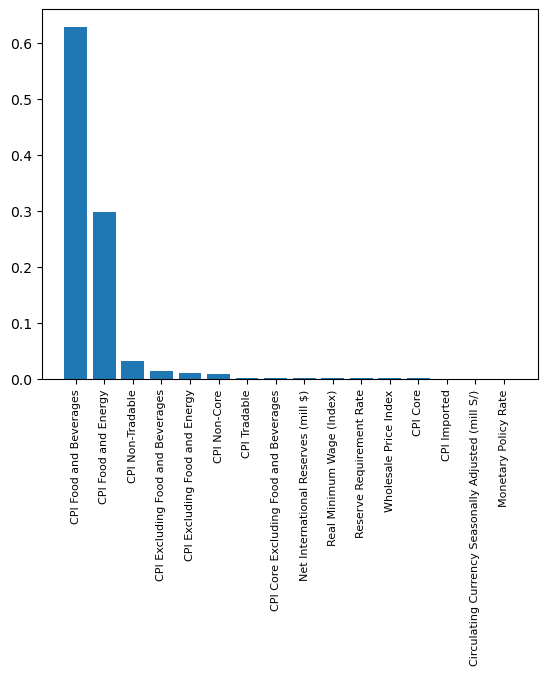

<Figure size 640x480 with 0 Axes>

In [43]:
graph_coefficients(vars_df_rf, value = "Importance Score")

plt.savefig("../../../output/3_Regression/h23/h23_coef_rf.png", bbox_inches='tight', dpi=300)